<p style="font-family: Arial; font-size:3.75em;color:purple; font-style:bold"><br>
Part 1: Histogram of Oriented Gradients 
</p><br>

<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>

Import Libraries
</p>

In [1]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
import cv2
import glob
from skimage.feature import hog
from sklearn.preprocessing import StandardScaler
import time
from sklearn.model_selection import train_test_split
from sklearn.svm import LinearSVC
import pickle
from scipy.ndimage.measurements import label
from collections import deque
#from skimage import color, exposure
# images are divided up into vehicles and non-vehicles
%matplotlib inline

<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>

Data Exploration
</p>

Your function returned a count of 8792  cars and 8968  non-cars
of size:  (64, 64, 3)  and data type: float32


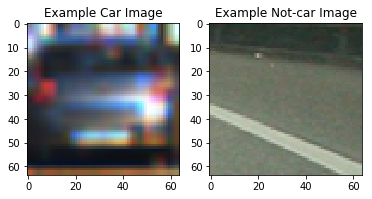

In [2]:
cars = glob.glob('vehicles/vehicles/**/*.png')
notcars = glob.glob('non-vehicles/non-vehicles/**/*.png')
        
# Define a function to return some characteristics of the dataset 
def data_look(car_list, notcar_list):
    data_dict = {}
    # Define a key in data_dict "n_cars" and store the number of car images
    data_dict["n_cars"] = len(car_list)
    # Define a key "n_notcars" and store the number of notcar images
    data_dict["n_notcars"] = len(notcar_list)
    # Read in a test image, either car or notcar
    example_img = mpimg.imread(car_list[0])
    # Define a key "image_shape" and store the test image shape 3-tuple
    data_dict["image_shape"] = example_img.shape
    # Define a key "data_type" and store the data type of the test image.
    data_dict["data_type"] = example_img.dtype
    # Return data_dict
    return data_dict
    
data_info = data_look(cars, notcars)

print('Your function returned a count of', 
      data_info["n_cars"], ' cars and', 
      data_info["n_notcars"], ' non-cars')
print('of size: ',data_info["image_shape"], ' and data type:', 
      data_info["data_type"])
# Just for fun choose random car / not-car indices and plot example images   
car_ind = np.random.randint(0, len(cars))
notcar_ind = np.random.randint(0, len(notcars))
    
# Read in car / not-car images
car_image = mpimg.imread(cars[car_ind])
notcar_image = mpimg.imread(notcars[notcar_ind])


# Plot the examples
fig = plt.figure()
plt.subplot(121)
plt.imshow(car_image)
plt.title('Example Car Image')
plt.subplot(122)
plt.imshow(notcar_image)
plt.title('Example Not-car Image')

<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>

A method using scikit-image HOG
</p>

D:\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


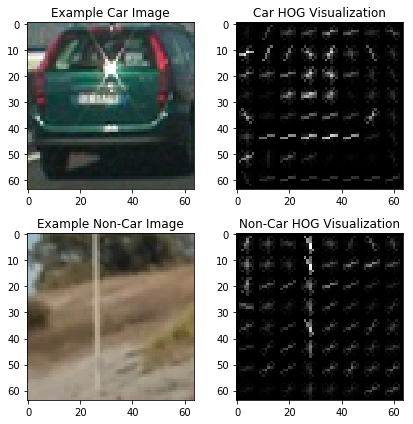

In [3]:
# Define a function to return HOG features and visualization
def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis=False, feature_vec=True):
    if vis == True:
        features, hog_image = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                                  visualise=True, feature_vector=False)
        return features, hog_image
    else:      
        features = hog(img, orientations=orient, pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), transform_sqrt=False, 
                       visualise=False, feature_vector=feature_vec)
        return features
    
# Define HOG parameters
orient = 9
pix_per_cell = 8
cell_per_block = 2

# Generate a random index to look at a car image
ind_car = np.random.randint(0, len(cars))
# Read in the image
image_car = mpimg.imread(cars[ind_car])
gray_car = cv2.cvtColor(image_car, cv2.COLOR_RGB2GRAY)

# Call our function with vis=True to see an image output
features_car, hog_image_car = get_hog_features(gray_car, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)

# Generate a random index to look at a not car image
ind_notcar = np.random.randint(0, len(notcars))
# Read in the image
image_notcar = mpimg.imread(notcars[ind_notcar])
gray_notcar = cv2.cvtColor(image_notcar, cv2.COLOR_RGB2GRAY)
# Call our function with vis=True to see an image output
features_notcar, hog_image_notcar = get_hog_features(gray_notcar, orient, 
                        pix_per_cell, cell_per_block, 
                        vis=True, feature_vec=False)



# Plot the examples
f, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(6,6))
ax1.imshow(image_car)
ax1.set_title('Example Car Image')
ax2.imshow(hog_image_car, cmap='gray')
ax2.set_title('Car HOG Visualization')
ax3.imshow(image_notcar)
ax3.set_title('Example Non-Car Image')
ax4.imshow(hog_image_notcar, cmap='gray')
ax4.set_title('Non-Car HOG Visualization')
plt.tight_layout()
plt.show()

<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>

Extract Features Function
</p>

In [4]:
# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    # Return the individual histograms, bin_centers and feature vector
    return hist_features

# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
def extract_features_color(imgs, cspace='RGB', spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
        else: feature_image = np.copy(image)      
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features)))
    # Return list of feature vectors
    return features


# Define a function to extract features from a list of images using HOG
def extract_features_hog(imgs, cspace='RGB', orient=9, 
                        pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)
            
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features


# Define a function to extract features from a list of images
def extract_features(imgs, cspace='RGB', orient=9,pix_per_cell=8, cell_per_block=2, hog_channel=0, spatial_size=(32, 32),
                        hist_bins=32, hist_range=(0, 256)):
     # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    for file in imgs:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if cspace != 'RGB':
            if cspace == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif cspace == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif cspace == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif cspace == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif cspace == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)
            
        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        
        # Apply bin_spatial() to get spatial color features
        spatial_features = bin_spatial(feature_image, size=spatial_size)
        # Apply color_hist() also with a color space option now
        hist_features = color_hist(feature_image, nbins=hist_bins, bins_range=hist_range)
        # Append the new feature vector to the features list
        features.append(np.concatenate((spatial_features, hist_features, hog_features)))    
    
    return features

<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>

Extract Features and Data Preparation
</p>

In [5]:
# Feature extraction parameters
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t = time.time()
car_features = extract_features_hog(cars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features_hog(notcars, cspace=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)


t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

# Create an array stack of feature vectors
X = np.vstack((car_features, notcar_features)).astype(np.float64)                        
# Fit a per-column scaler
X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
scaled_X = X_scaler.transform(X)

# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))



# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=rand_state)

print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))

D:\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


45.38 Seconds to extract HOG features...
Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1188


<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>

Train a Classifier
</p>

In [6]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
t=time.time()
n_predict = 10
print('My SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For these',n_predict, 'labels: ', y_test[0:n_predict])
t2 = time.time()
print(round(t2-t, 5), 'Seconds to predict', n_predict,'labels with SVC')

1.32 Seconds to train SVC...
Test Accuracy of SVC =  0.9848
My SVC predicts:  [ 1.  1.  0.  1.  1.  0.  1.  0.  1.  1.]
For these 10 labels:  [ 1.  1.  0.  1.  1.  0.  1.  0.  1.  1.]
0.0015 Seconds to predict 10 labels with SVC


<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>
Save the Data
</p>

In [7]:
# Save the train and test data
with open('trian_test.p', 'wb') as pfile:
    pickle.dump(
            {
                'X_train': X_train,
                'X_test': X_test,
                'y_train': y_train,
                'y_test': y_test                
            },
            pfile, pickle.HIGHEST_PROTOCOL)    

# Save the classifier model
with open('classifier.p', 'wb') as pfile:
    pickle.dump(
            {   'svc':svc
            },
            pfile, pickle.HIGHEST_PROTOCOL)
    
print('Data have been saved!')

Data have been saved!


<p style="font-family: Arial; font-size:3.75em;color:purple; font-style:bold"><br>
Part 2: Sliding Window Search
</p><br>

<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>

Load the classifier model
</p>

In [8]:
with open('classifier.p', mode='rb') as f:
    data = pickle.load(f)
svc = data['svc'] 

<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>

Hog Sub-sampling Window Search
</p>

D:\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


4 rectangles found in test image


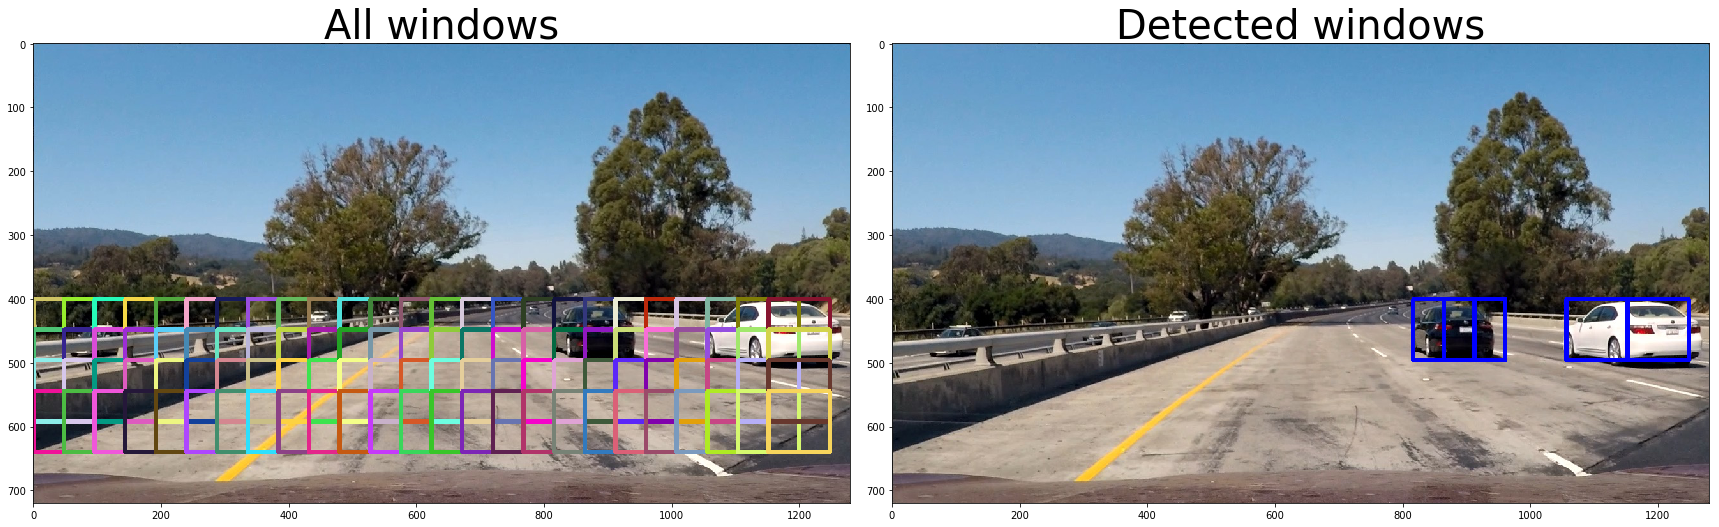

In [9]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cspace, hog_channel, svc, X_scaler, orient, 
              pix_per_cell, cell_per_block, all_rectangels=False):
    
    # array of rectangles where cars were detected
    rectangles = []
    rectangles_all = []
    
    draw_img = np.copy(img)
    draw_all_rectangle = np.copy(img)
    img = img.astype(np.float32)/255
    
    img_tosearch = img[ystart:ystop,:,:]

    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)   
    
    # rescale image if other than 1.0 scale
    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
    
    # select colorspace channel for HOG 
    if hog_channel == 'ALL':
        ch1 = ctrans_tosearch[:,:,0]
        ch2 = ctrans_tosearch[:,:,1]
        ch3 = ctrans_tosearch[:,:,2]
    else: 
        ch1 = ctrans_tosearch[:,:,hog_channel]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell)+1  #-1
    nyblocks = (ch1.shape[0] // pix_per_cell)+1  #-1 
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell)-1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)   
    if hog_channel == 'ALL':
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            # Extract HOG for this patch
            hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            if hog_channel == 'ALL':
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog_feat1

            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell            
            test_prediction = svc.predict([hog_features])
            
            if test_prediction == 1:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                cv2.rectangle(draw_img,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),(0,0,255),6) 
                rectangles.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))   
            if all_rectangels is True:
                xbox_left = np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
                #color = (0, 0, 255)
                cv2.rectangle(draw_all_rectangle,(xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart),color,6)
                rectangles_all.append(((xbox_left, ytop_draw+ystart),(xbox_left+win_draw,ytop_draw+win_draw+ystart)))   
                
    return rectangles, rectangles_all, draw_img, draw_all_rectangle

# Test the find_car() function
def test_find_cars(img_path, ystart, ytstop, scale):
    img = mpimg.imread(img_path)    
    ystart = ystart
    ystop = ytstop
    scale = scale

    # Feature extraction parameters
    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

    rectangles, _, out_img, all_img= find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, all_rectangels=True)
    print(len(rectangles), 'rectangles found in test image')
    plt.figure()    
    # Plot the result
    f, (ax1,ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(all_img)
    ax1.set_title('All windows', fontsize=40)
    ax2.imshow(out_img)
    ax2.set_title('Detected windows', fontsize=40)
    plt.show()
test_find_cars('./test_images/test1.jpg', 400, 656, 1.5)

D:\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


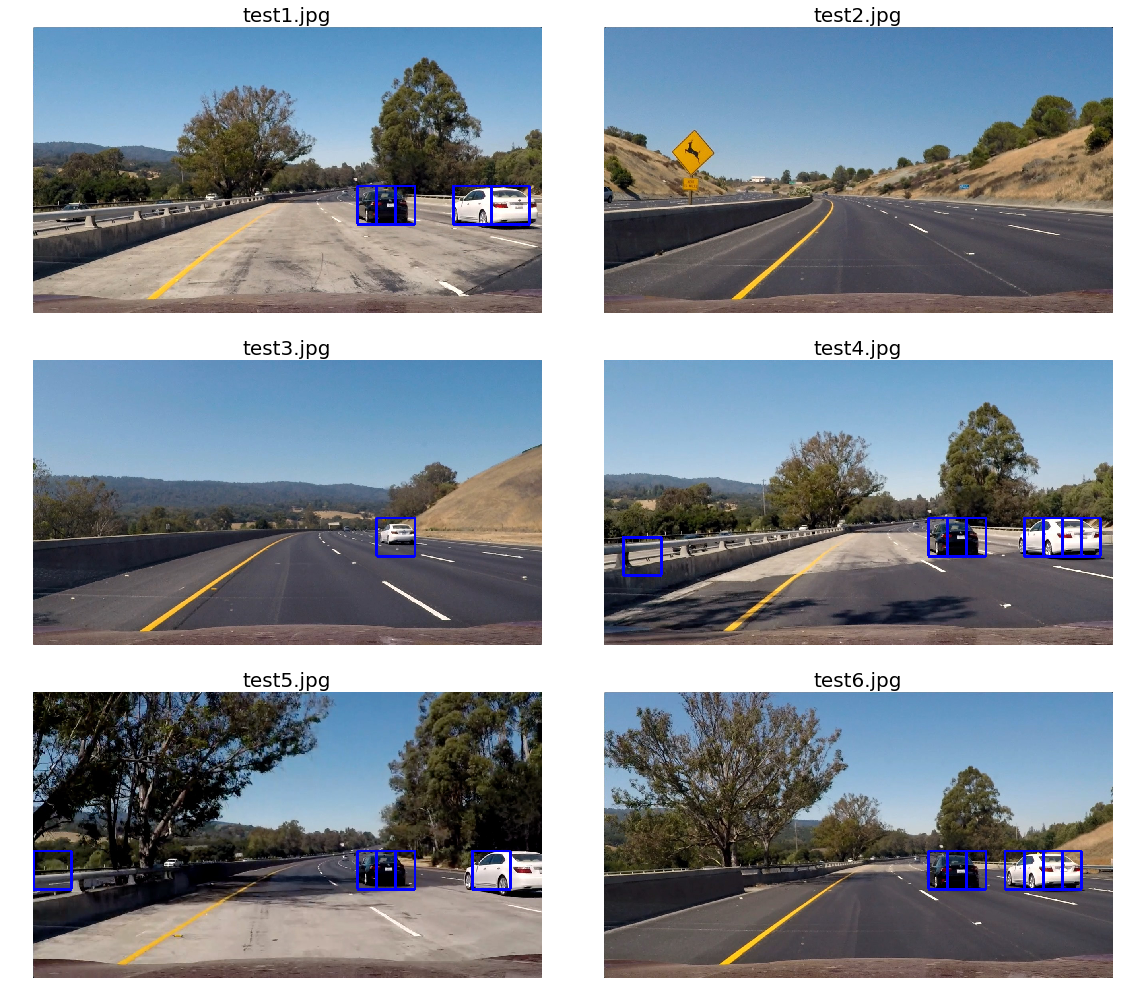

In [10]:
### Test the find cars on all the test images
test_images = glob.glob('./test_images/test*.jpg')
fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    img = mpimg.imread(im)    
    ystart = 400
    ystop = 656
    scale = 1.5

    # Feature extraction parameters
    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

    _, _, out_img, _= find_cars(img, ystart, ystop, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, all_rectangels=False)
    axs[i].imshow(out_img)
    axs[i].set_title('test'+str(i+1)+'.jpg', fontsize=20)
    axs[i].axis('off')
# Show all the images in the figure    
plt.tight_layout()
plt.show()

<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>

Search in different scales
</p>

As the udacity lesson described,  Each window is defined by a scaling factor where a scale of 1 would result in a window that's 8 x 8 cells then the overlap of each window is in terms of the cell distance. 1 cell is 8 x 8 pixels. So we can use different scale based on the **y pixels** of 1 window: **1 scale ->64 pixels; 1.5 scale -> 96 pixels; 2 scale-> 128 pixels; 2.5 scale -> 160 pixels; 3 scale -> 192 pixels; 3.5 scale -> 224 pixels.** 

This means that a cells_per_step = 2 would result in a search window overlap of 75%, so if you want to find a cell of next row , you shuold move down **15%** scale pixels(ex: 1 scale moved down **16** pixels to make a new cell.)

In order to search efficiently and not to find a lot duplicate region, I wil define differnt scale only on searching 2 rows:
   * 1 scale: (start:400, stop:464) ; (start:416, stop:480)
   * 1.5 scale: (start: 400, stop:496); (start:424, stop:520)
   * 2 scale:(start: 400, stop:528); (start:432, stop:560)
   * 2.5 scale(start: 400, stop:560); (start:440, stop:600)
   * 3 scale(start:400, stop:592); (start:448, stop:640)
   * 3.5 scale(start:400, stop:624);(start:456, stop:680) 

D:\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


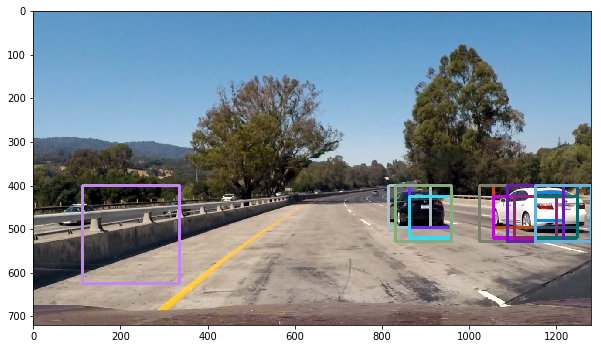

In [11]:
def find_all_scales(img, draw_rectangles=False):
    
    # Rectangle list to store different scales window
    rectangles_list = []
    
    # Feature extraction parameters
    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    
    # Define which the scales list 
    scale_list = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5]    

    # Save diffent y range and scaled winow
    for scale in scale_list:
        if scale == 1.0:
            rectangles,_, _, _= find_cars(img, 400, 464, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, all_rectangels=False)
            rectangles_list.append(rectangles)
            rectangles,_, _, _= find_cars(img, 416, 480, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, all_rectangels=False)
            rectangles_list.append(rectangles)
        elif scale == 1.5:
            rectangles,_, _, _= find_cars(img, 400, 496, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, all_rectangels=False)
            rectangles_list.append(rectangles)
            rectangles,_, _, _= find_cars(img, 424, 520, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, all_rectangels=False)
            rectangles_list.append(rectangles)
        elif scale == 2.0:
            rectangles,_, _, _= find_cars(img, 400, 528, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, all_rectangels=False)
            rectangles_list.append(rectangles)
            rectangles,_, _, _= find_cars(img, 432, 560, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, all_rectangels=False)
            rectangles_list.append(rectangles)        
        
        elif scale == 3.5:
            rectangles, _, _,_= find_cars(img, 400, 624, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, all_rectangels=False)
            rectangles_list.append(rectangles)
            rectangles, _, _,_= find_cars(img, 456, 680, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, all_rectangels=False)
            rectangles_list.append(rectangles)
        """
        elif scale == 2.5:
            rectangles,_, _, _= find_cars(img, 400, 560, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, all_rectangels=False)
            rectangles_list.append(rectangles)
            rectangles,_, _, _= find_cars(img, 440, 600, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, all_rectangels=False)
            rectangles_list.append(rectangles)
        elif scale == 3.0:
            rectangles,_, _, _= find_cars(img, 400, 592, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, all_rectangels=False)
            rectangles_list.append(rectangles)
            rectangles,_, _, _= find_cars(img, 448, 656, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, all_rectangels=False)
            rectangles_list.append(rectangles)
        """
    rectangles = [item for sublist in rectangles_list for item in sublist] 
    # Draw boxes
    # Make a copy of the image
    imcopy = np.copy(img)
    if draw_rectangles is True:        
        # Iterate through the bounding boxes
        for bbox in rectangles:
            color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
            # Draw a rectangle given bbox coordinates
            cv2.rectangle(imcopy, bbox[0], bbox[1], color, 6)
        
    return imcopy, rectangles

test_img_rectangles, rectangles = find_all_scales(mpimg.imread('./test_images/test1.jpg'), draw_rectangles=True)
plt.figure(figsize=(10,15))
plt.imshow(test_img_rectangles)

D:\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


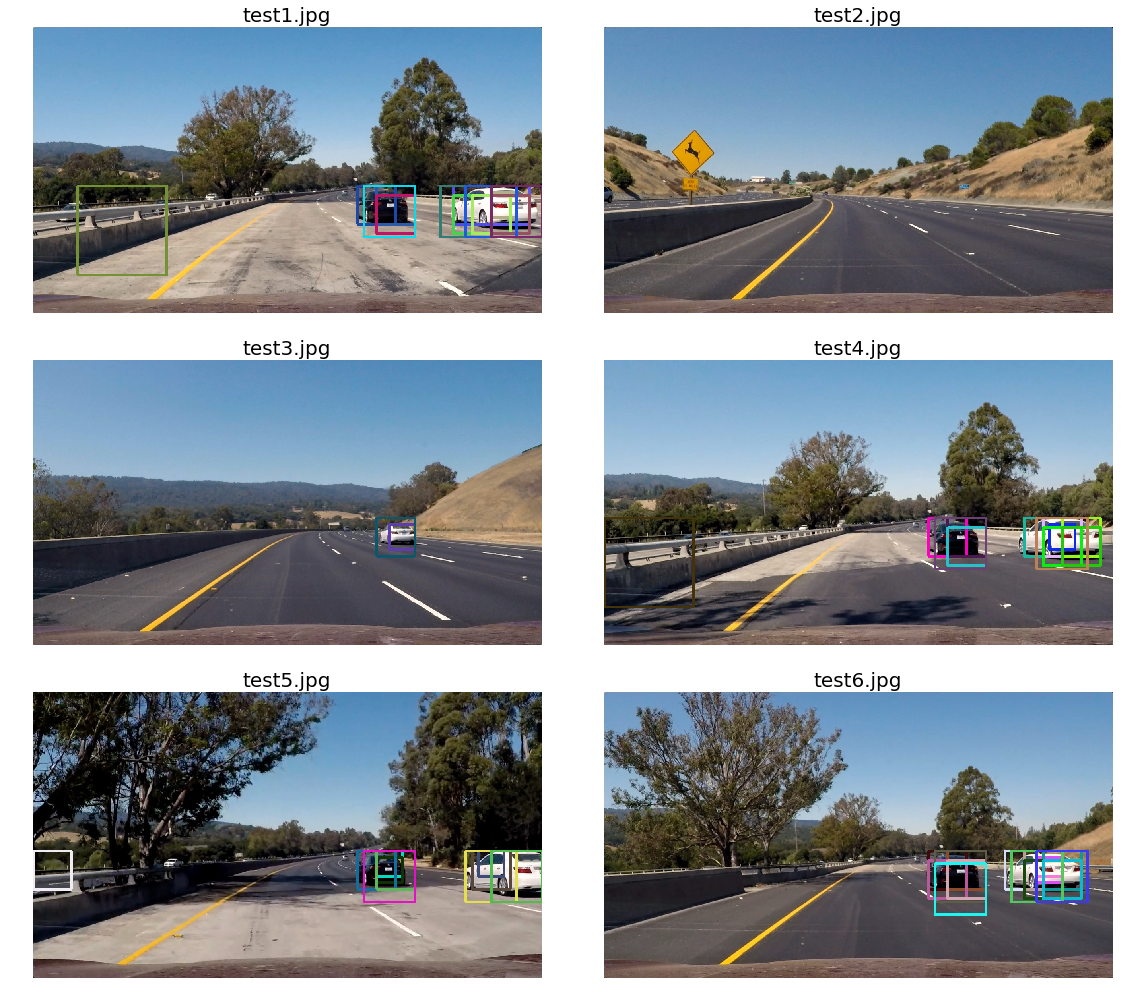

In [12]:
### Test the find all scales on all the test images
test_images = glob.glob('./test_images/test*.jpg')
fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    img = mpimg.imread(im)  

    out_img, _ = find_all_scales(img, draw_rectangles=True)
    axs[i].imshow(out_img)
    axs[i].set_title('test'+str(i+1)+'.jpg', fontsize=20)
    axs[i].axis('off')
# Show all the images in the figure    
plt.tight_layout()
plt.show()

D:\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


186 rectangles found.


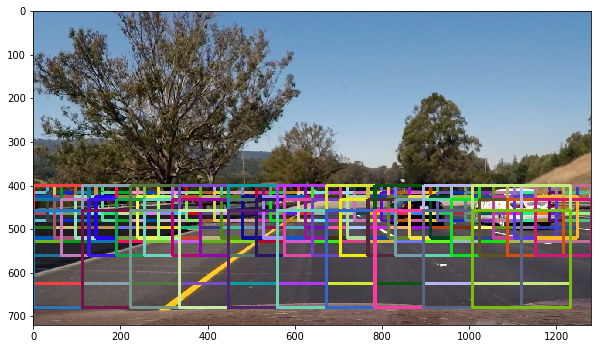

In [13]:
### Draw all scales on one image
def draw_all_scales(img):
    # Rectangle list to store different scales window
    rectangles_list = []
    
    # Feature extraction parameters
    colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
    orient = 11
    pix_per_cell = 16
    cell_per_block = 2
    hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"
    
    # Define which the scales list 
    scale_list = [1.0, 1.5, 2.0, 2.5, 3.0, 3.5]    

    # Save diffent y range and scaled winow
    for scale in scale_list:
        if scale == 1.0:
            _,rectangles,_, _= find_cars(img, 400, 464, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, all_rectangels=True)
            rectangles_list.append(rectangles)
            _,rectangles,_, _= find_cars(img, 416, 480, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, all_rectangels=True)
            rectangles_list.append(rectangles)
        elif scale == 1.5:
            _,rectangles,_, _= find_cars(img, 400, 496, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, all_rectangels=True)
            rectangles_list.append(rectangles)
            _,rectangles,_, _= find_cars(img, 424, 520, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, all_rectangels=True)
            rectangles_list.append(rectangles)
        elif scale == 2.0:
            _,rectangles,_, _= find_cars(img, 400, 528, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, all_rectangels=True)
            rectangles_list.append(rectangles)
            _,rectangles,_, _= find_cars(img, 432, 560, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, all_rectangels=True)
            rectangles_list.append(rectangles)
        elif scale == 3.5:
            _,rectangles, _, _= find_cars(img, 400, 624, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, all_rectangels=True)
            rectangles_list.append(rectangles)
            _,rectangles, _, _= find_cars(img, 456, 680, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, all_rectangels=True)
            rectangles_list.append(rectangles)
        """
        elif scale == 2.5:
            _,rectangles,_, _= find_cars(img, 400, 560, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, all_rectangels=True)
            rectangles_list.append(rectangles)
            _,rectangles,_, _= find_cars(img, 440, 600, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, all_rectangels=True)
            rectangles_list.append(rectangles)
        elif scale == 3.0:
            _,rectangles,_, _= find_cars(img, 400, 592, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, all_rectangels=True)
            rectangles_list.append(rectangles)
            _,rectangles,_, _= find_cars(img, 448, 656, scale, colorspace, hog_channel, svc, None, orient, pix_per_cell, cell_per_block, all_rectangels=True)
            rectangles_list.append(rectangles)
        """
            
    rectangles = [item for sublist in rectangles_list for item in sublist] 
    print(len(rectangles), 'rectangles found.')
    # Draw boxes
    # Make a copy of the image
    imcopy = np.copy(img)
    random_color = False
    # Iterate through the bounding boxes
    for bbox in rectangles:
        color = (np.random.randint(0,255), np.random.randint(0,255), np.random.randint(0,255))
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, 6)
        
    plt.figure(figsize=(10,15))
    plt.imshow(imcopy)

draw_all_scales(img)       

<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>

False Positives using Heat Map
</p>

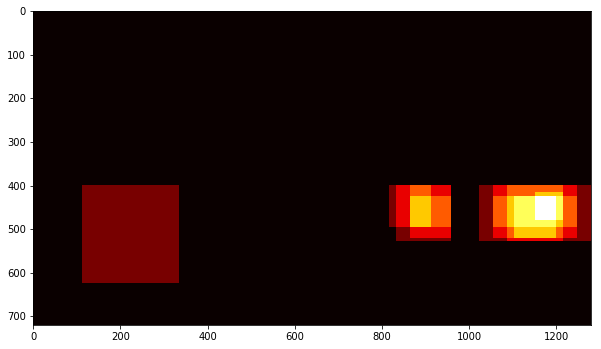

In [14]:
### Add heat map
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap

# Test the add heat map
heatmap_img = np.zeros_like(test_img_rectangles[:,:,0])
heatmap_img = add_heat(heatmap_img, rectangles)
plt.figure(figsize=(10,15))
plt.imshow(heatmap_img, cmap='hot')

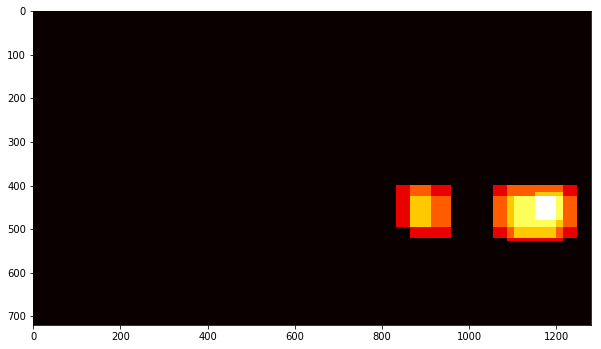

In [15]:
### Apply Threshold
def apply_threshold(heatmap, threshold):
    # Zero out pixels below the threshold
    heatmap[heatmap <= threshold] = 0
    # Return thresholded map
    return heatmap


# Test the apply_threshold
heatmap_img = apply_threshold(heatmap_img, 1)
plt.figure(figsize=(10,15))
plt.imshow(heatmap_img, cmap='hot')

2 cars found


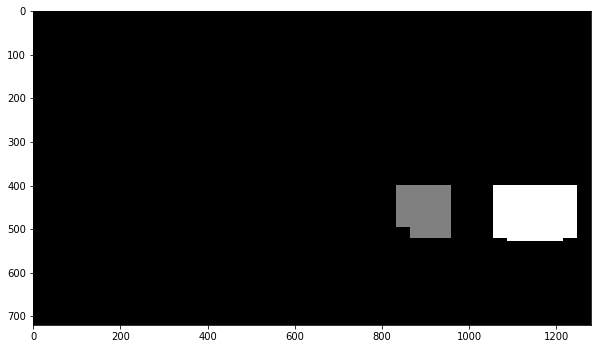

In [16]:
### Apply  SciPy Labels 
labels = label(heatmap_img)
print(labels[1], 'cars found')
plt.figure(figsize=(10,15))
plt.imshow(labels[0], cmap='gray')

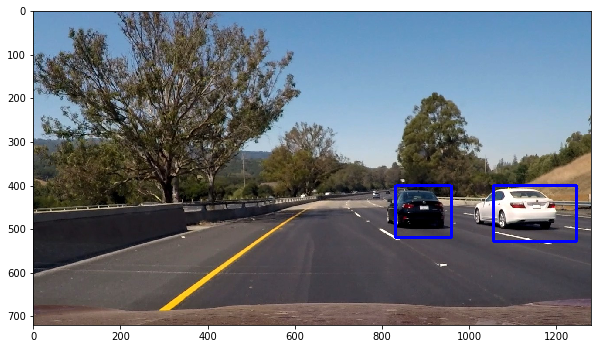

In [17]:
### Draw Bounding Boxes for Lables
def draw_labeled_bboxes(img, labels):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], (0,0,255), 6)
    # Return the image
    return img


# Draw bounding boxes on a copy of the image
draw_img = draw_labeled_bboxes(np.copy(img), labels)
# Display the image
plt.figure(figsize=(10,15))
plt.imshow(draw_img)

<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>

Putting all previous steps to form a Pipline to process the frame image
</p>

D:\Anaconda3\envs\carnd-term1\lib\site-packages\skimage\feature\_hog.py:119: skimage_deprecation: Default value of `block_norm`==`L1` is deprecated and will be changed to `L2-Hys` in v0.15
  'be changed to `L2-Hys` in v0.15', skimage_deprecation)


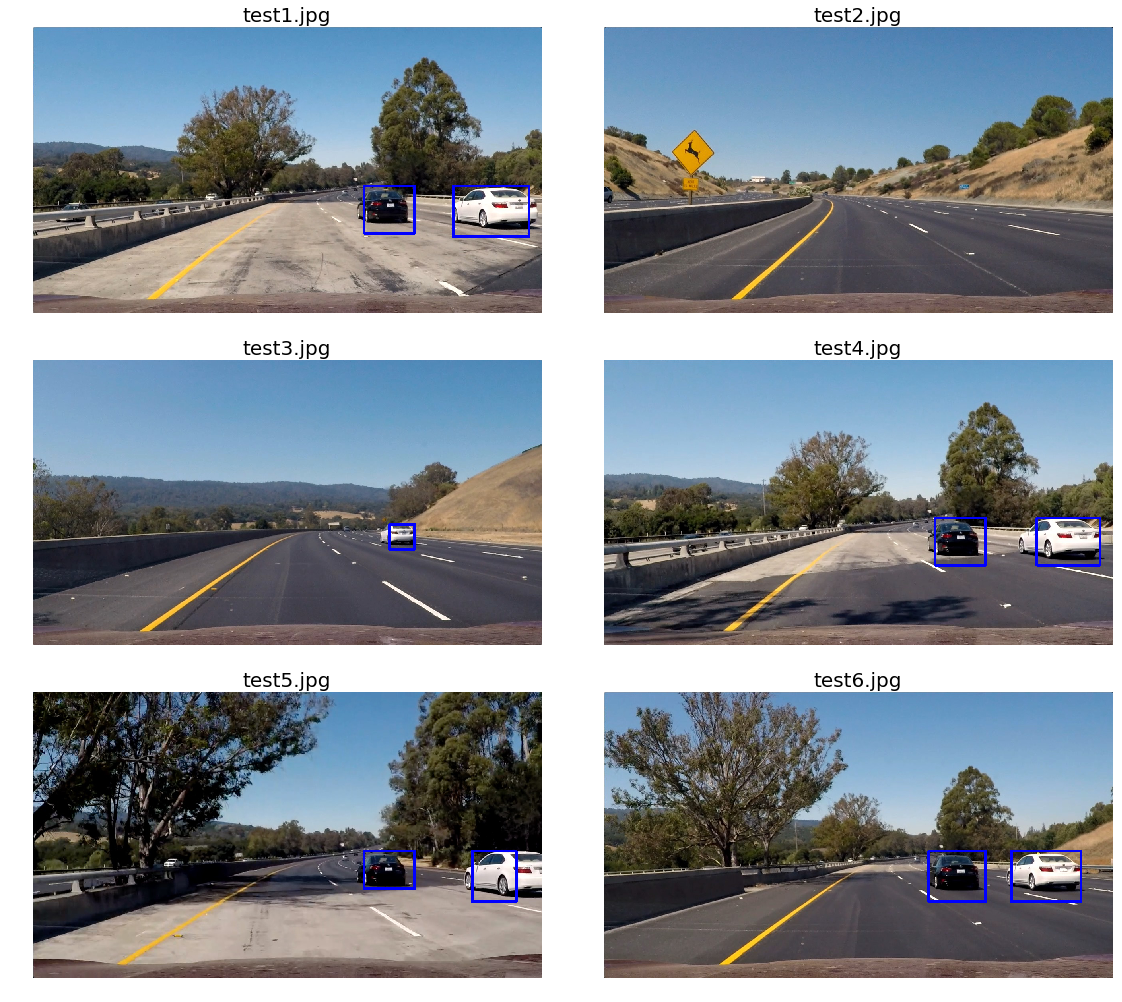

In [18]:
def process_image(image):
    # Search different scales window
    _, rectangles = find_all_scales(image)
    
    # Add heat map
    heatmap_img = np.zeros_like(image[:,:,0])
    heatmap_img = add_heat(heatmap_img, rectangles)
    
    ### Apply Threshold
    heatmap_img = apply_threshold(heatmap_img, 1)
    labels = label(heatmap_img)
    
    ### Draw Bounding Boxes for Lables
    result = draw_labeled_bboxes(np.copy(image), labels)
    return result

# Test the pipleline on all the test images
test_images = glob.glob('./test_images/test*.jpg')
fig, axs = plt.subplots(3, 2, figsize=(16,14))
fig.subplots_adjust(hspace = .004, wspace=.002)
axs = axs.ravel()

for i, im in enumerate(test_images):
    axs[i].imshow(process_image(mpimg.imread(im)))
    axs[i].set_title('test'+str(i+1)+'.jpg', fontsize=20)
    axs[i].axis('off')
# Show all the images in the figure    
plt.tight_layout()
plt.show()

<p style="font-family: Arial; font-size:3.75em;color:purple; font-style:bold"><br>
Part 3: Video Implementation
</p><br>

<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>

Run Pipeline on test video
</p>

In [19]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

white_output = 'test_video_output.mp4'
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(process_image)
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video test_video_output.mp4
[MoviePy] Writing video test_video_output.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:11<00:00,  3.52it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output.mp4 

Wall time: 12.3 s


<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>

Refine the Pipeline to store the previous frames and select the interested region
</p>

In [20]:
# Applies an image mask.
def region_of_interest(img, vertices):
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image

# Define a deque to store the previous frames
recent_frames = deque([], maxlen=10)


### Pipeline Refine
def process_image_refine(image):    
    # This time we are defining a four sided polygon to mask
    img_mask = np.copy(image)
    imshape = img_mask.shape
    vertices = np.array([[(0,imshape[0]),(550,400), (imshape[1], 0), (imshape[1],imshape[0])]], dtype=np.int32)
    img_mask = region_of_interest(img_mask, vertices)
    
    # Search different scales window
    _, rectangles = find_all_scales(img_mask)
    
    global recent_frames
    
    if len(rectangles) >  0:
        if(len(recent_frames) < 10):
            recent_frames.append(rectangles)
        else:
            recent_frames.popleft()
            recent_frames.append(rectangles)
    
    # Add heat map
    heatmap_img = np.zeros_like(image[:,:,0])
    for rec in recent_frames:
        heatmap_img = add_heat(heatmap_img, rec)
    
    ### Apply Threshold
    heatmap_img = apply_threshold(heatmap_img, len(recent_frames) // 2 + 1)
    #heatmap_img = apply_threshold(heatmap_img, 4)
    labels = label(heatmap_img)
    
    ### Draw Bounding Boxes for Lables
    result = draw_labeled_bboxes(np.copy(image), labels)
    return result

<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>

Run the refined Pinpline on the test video
</p>

In [21]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Clear the stroe deque
recent_frames.clear()

white_output = 'test_video_output_2.mp4'
clip1 = VideoFileClip("test_video.mp4")
white_clip = clip1.fl_image(process_image_refine)
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video test_video_output_2.mp4
[MoviePy] Writing video test_video_output_2.mp4


 97%|███████████████████████████████████████████████████████████████████████████████▉  | 38/39 [00:10<00:00,  3.78it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_video_output_2.mp4 

Wall time: 10.7 s


<p style="font-family: Arial; font-size:1.75em;color:#2462C0; font-style:bold"><br>

Process the project video
</p>

In [22]:
from moviepy.editor import VideoFileClip
from IPython.display import HTML

# Clear the stroe deque
recent_frames.clear()

white_output = 'project_video_output.mp4'
clip1 = VideoFileClip("project_video.mp4")
white_clip = clip1.fl_image(process_image_refine)
%time white_clip.write_videofile(white_output, audio=False)

HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

[MoviePy] >>>> Building video project_video_output.mp4
[MoviePy] Writing video project_video_output.mp4


100%|█████████████████████████████████████████████████████████████████████████████▉| 1260/1261 [05:48<00:00,  3.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: project_video_output.mp4 

Wall time: 5min 48s
